# Compute the OOD score during Insertion and Deletion

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  plt.rcParams["figure.figsize"] = [w,h]

def fontsize(mult):
  matplotlib.rcParams.update({'font.size': 12 * mult})

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

all_cmaps = []

def get_alpha_cmap(rgb_color):
    # Normalize the RGB color values to the range [0, 1]
    rgb_color = np.array(rgb_color) / 255.0

    # Create an alpha colormap with varying alpha values
    cmap_data = {'red':   [(0, rgb_color[0], rgb_color[0]),
                           (1, rgb_color[0], rgb_color[0])],
                 'green': [(0, rgb_color[1], rgb_color[1]),
                           (1, rgb_color[1], rgb_color[1])],
                 'blue':  [(0, rgb_color[2], rgb_color[2]),
                           (1, rgb_color[2], rgb_color[2])],
                 'alpha': [(0, 0, 0),
                           (1, 1, 1)]}

    alpha_cmap = mcolors.LinearSegmentedColormap('alpha_cmap', cmap_data, N=256)

    all_cmaps.append(alpha_cmap)

    return alpha_cmap

slack_blue  = get_alpha_cmap((54, 197, 240))
slack_green = get_alpha_cmap((46, 182, 125) )
slack_red   = get_alpha_cmap((210, 40, 95))
slack_yellow = get_alpha_cmap((236, 178, 46))
slack_violet = get_alpha_cmap((84, 25, 85))

google_blue = get_alpha_cmap((66, 133, 244))
google_red = get_alpha_cmap((219, 68, 55))
google_yellow= get_alpha_cmap((244, 180, 0))
google_green = get_alpha_cmap((15, 157, 88))

deep_purple = get_alpha_cmap((103, 58, 183))
pink = get_alpha_cmap((236, 64, 122))
anthracite = get_alpha_cmap((13, 13, 21))

palette_1 = get_alpha_cmap((33, 115, 174))
palette_2 = get_alpha_cmap((216, 146, 49))
palette_3 = get_alpha_cmap((58, 155, 118))
palette_4 = get_alpha_cmap((210, 158, 201))

import scipy
import matplotlib as mpl
mpl.rcdefaults()
fontsize(1.3)
set_size(7, 5)
# plt.style.use("seaborn-ticks")

2024-07-02 15:17:18.071810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 15:17:47.010578: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cudnn/11.8-v8.8.1/cuda/lib64:/usr/local/cuda-11.8/lib64
2024-07-02 15:17:47.010760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cudnn/11.8-v8.8.1/cuda/lib64:/usr/local/cuda-11.8/li

### Set up the model and dataset

In [2]:
model = tf.keras.applications.ResNet50V2(classifier_activation=None)
feature_model = tf.keras.Model(model.input, model.layers[-2].output)

def preprocess(images):
  return tf.keras.applications.resnet_v2.preprocess_input(np.array(images, dtype=np.float32))

2024-07-02 15:19:15.919569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-02 15:19:15.919823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-02 15:19:15.942460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-02 15:19:15.942719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-02 15:19:15.942917: I tensorflow/compiler/xla/stream_executo

In [3]:
X = np.load('../imagenet_samples.npy')
X = preprocess(X)
Y = tf.one_hot(np.argmax(model.predict(X, 256), -1), 1_000)
X.shape, Y.shape

2024-07-02 15:19:25.914847: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 120422400 exceeds 10% of free system memory.
2024-07-02 15:19:26.042950: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 120422400 exceeds 10% of free system memory.
2024-07-02 15:19:26.547354: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 120422400 exceeds 10% of free system memory.
2024-07-02 15:19:26.740574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801


1/1 [==============================] - 2s 2s/step


2024-07-02 15:19:27.642788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


((200, 224, 224, 3), TensorShape([200, 1000]))

In [4]:
Bank_images = np.load('../imagenet_samples_5000.npy')
Bank_images = preprocess(Bank_images)
Bank = feature_model.predict(Bank_images, batch_size=128)

2024-07-02 15:19:49.419696: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3010560000 exceeds 10% of free system memory.
2024-07-02 15:19:52.361091: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3010560000 exceeds 10% of free system memory.


40/40 [==============================] - 3s 53ms/step


### Define the baselines

In [5]:
from xplique.attributions import *
from xplique.metrics import *

In [6]:
def permute_ax1(x):
  x = x.copy()
  x = np.moveaxis(x, 1, 0)
  np.random.shuffle(x)
  x = np.moveaxis(x, 1, 0)
  return x

def random_permute(x):
  x = np.array(x).copy()
  s = x.shape
  x = x.reshape((len(x), -1, 3))
  x = permute_ax1(x)
  return x.reshape(s)

def downsample_upsample(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = tf.image.resize(x, s, method="nearest")
  return x

def local_permute(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = random_permute(x)
  x = tf.image.resize(x, s, method="nearest")
  return x

def scramble_phase(x):
  spectrum = np.fft.fft2(x)
  amplitude = np.abs(spectrum)

  phase = np.angle(spectrum)
  phase = random_permute(phase)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x

def scramble_amplitude(x):
  spectrum = np.fft.fft2(x)

  amplitude = np.abs(spectrum)
  amplitude = random_permute(amplitude)

  phase = np.angle(spectrum)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x


baselines = {
    'zero': lambda x : tf.zeros(x.shape),
    'uniform': lambda x : tf.random.uniform(x.shape, -1, 1),
    'normal': lambda x : tf.clip_by_value(tf.random.normal(x.shape), -1, 1),
    'permutation': lambda x : random_permute(x),
    'local_mean': lambda x : downsample_upsample(x),
    'local_permutation': lambda x : local_permute(x),
    'mean': lambda x : np.ones(x.shape) * np.mean(x, (1, 2))[:, None, None, :],
    'median': lambda x : np.ones(x.shape) * np.median(x, (1, 2))[:, None, None, :],
    'random_color': lambda x : np.ones(x.shape) * (np.random.rand(3) * 2 - 1.),
    'scramble_phase': lambda x : scramble_phase(x),
    'scramble_amplitude': lambda x : scramble_amplitude(x)
}

### Load the explanations and generate the Deletion paths

In [7]:
def generate_path_deletion(images, explanations, baseline_func, steps=10):
  images_flatten = np.array(images).reshape((len(images), -1, images.shape[-1]))

  min_img = np.min(images, (1,2,3))
  max_img = np.max(images, (1,2,3))

  if len(explanations.shape) == 4:
    explanations = np.mean(explanations, -1)

  explanations_flatten = explanations.reshape((len(explanations), -1))
  most_important_features = np.argsort(explanations_flatten, axis=-1)[:, ::-1]

  baselines = np.array(baseline_func(images))
  baselines_flatten = baselines.reshape((len(images), -1, images.shape[-1]))

  steps = np.linspace(0, baselines_flatten.shape[1], steps + 1, dtype=np.int32)

  start = images_flatten
  end = baselines_flatten

  ret = []

  for step in steps:
    ids_to_flip = most_important_features[:, :step]
    batch_inputs = start.copy()

    for i, ids in enumerate(ids_to_flip):
      batch_inputs[i, ids] = end[i, ids]

    batch_inputs = batch_inputs.reshape(images.shape)
    batch_inputs = np.clip(batch_inputs, min_img[:, None, None, None], max_img[:, None, None, None])
    ret.append(batch_inputs)

  return ret

In [8]:
H = np.load('./resnet50_GradCAM.npy')  # explanations generated using the other notebook!
H.shape

(200, 224, 224, 1)

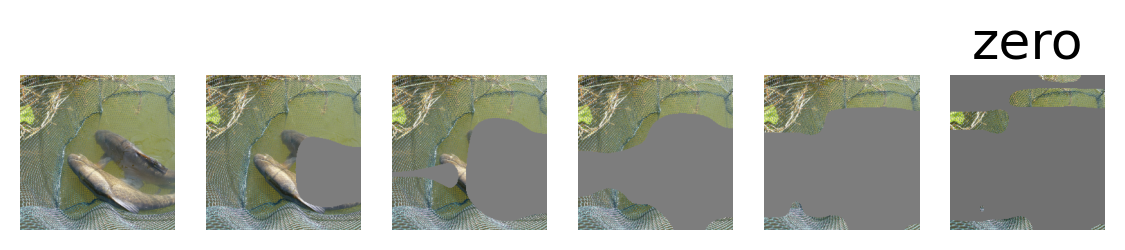

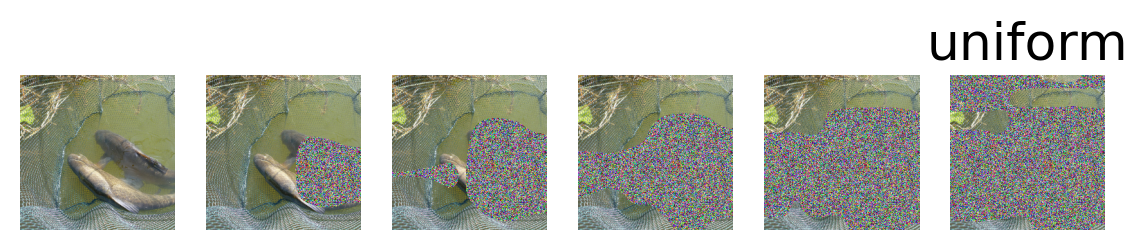

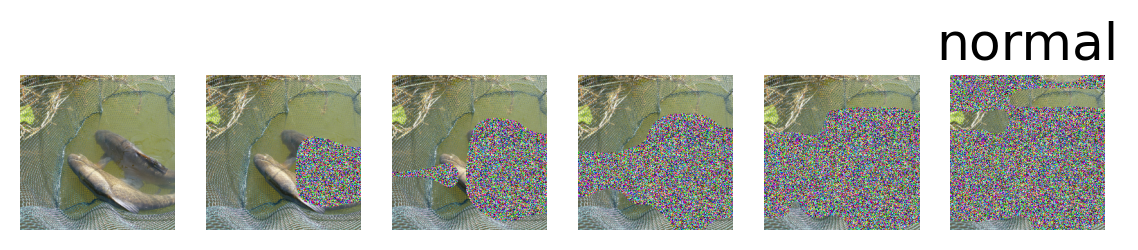

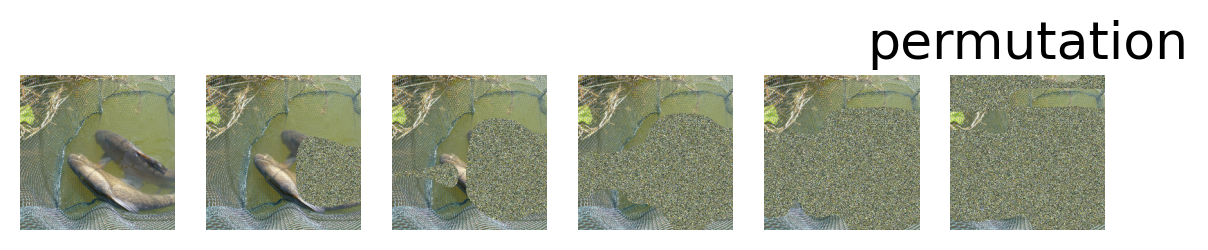

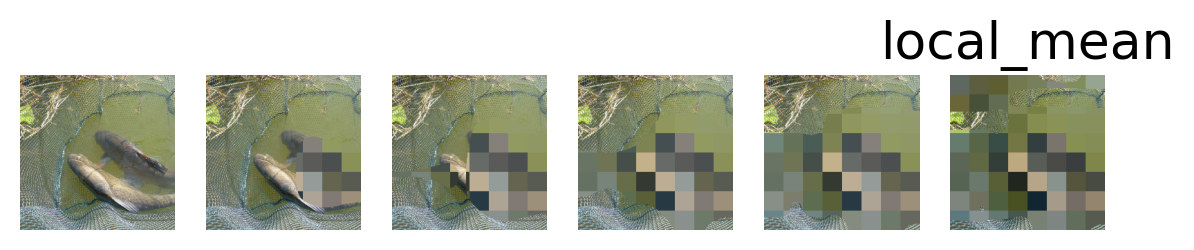

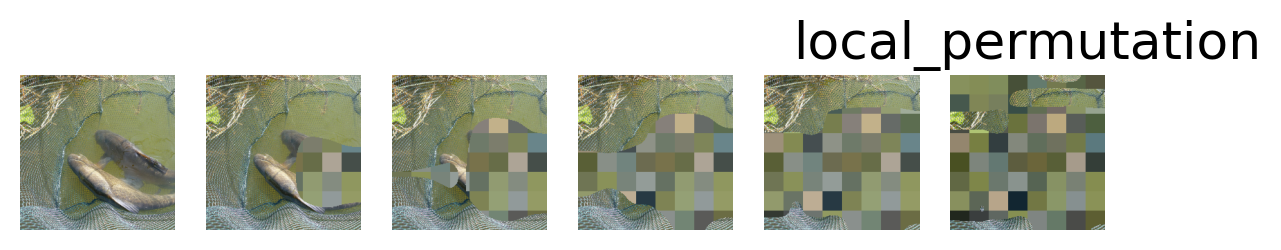

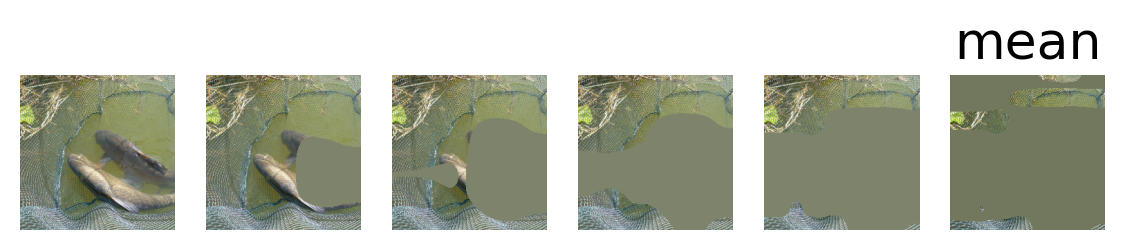

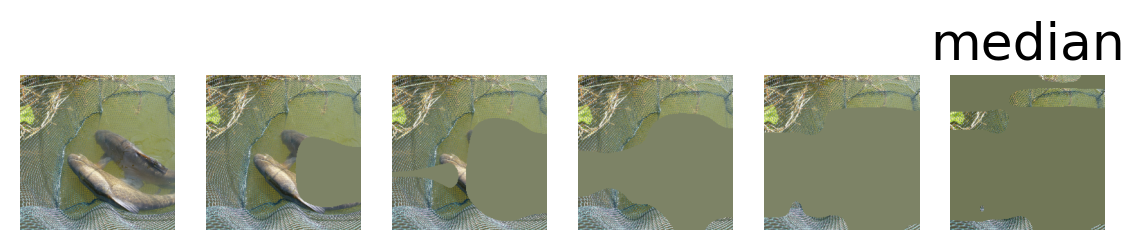

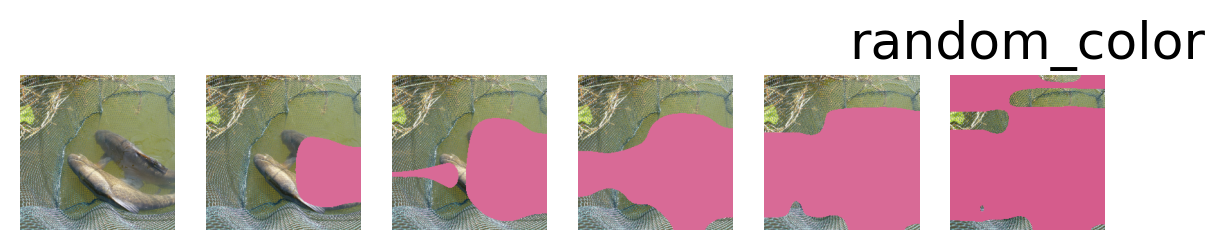

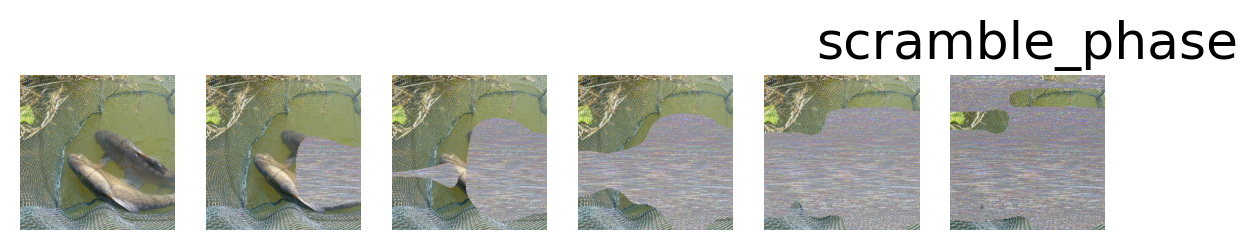

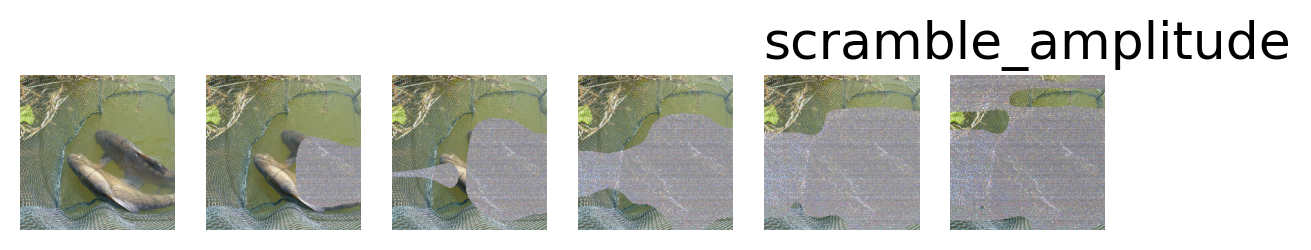

In [9]:
# Plot the paths to see what it looks like
steps = 6

for baseline_name, baseline_func in baselines.items():
  chunks = generate_path_deletion(np.array(X[:10]), np.array(H[:10]), baseline_func, steps=steps)

  for i in range(steps):
    plt.subplot(1, steps, i+1)
    show(chunks[i][0])
  plt.title(baseline_name)
  plt.show()

### Compute the OOD score for Deletion paths

We follow the definition from DeepKNN (https://proceedings.mlr.press/v162/sun22d/sun22d.pdf)

In [10]:
def l2_pairwise(a, b):
  na = tf.reduce_sum(tf.square(a), 1)
  nb = tf.reduce_sum(tf.square(b), 1)

  na = tf.reshape(na, [-1, 1])
  nb = tf.reshape(nb, [1, -1])

  # return pairwise euclidean difference matrix
  d = tf.sqrt(tf.maximum(na - 2*tf.linalg.matmul(a, b, False, True) + nb, 0.0))
  return d

def compute_ood_score(images):
  activations = feature_model.predict(images, batch_size=128)
  distances = l2_pairwise(activations, Bank)
  scores = np.min(distances, -1)

  return scores

In [26]:
steps = 20

RESULTS = {}

for baseline_name, baseline_func in baselines.items():
  RESULTS[baseline_name] = []

  chunks = generate_path_deletion(np.array(X[:len(H)]), np.array(H), baseline_func, steps=steps)

  for step_id in range(steps):
    ood_scores = compute_ood_score(chunks[step_id])
    RESULTS[baseline_name].append((step_id, ood_scores))

  print("done for", baseline_name)

2/2 [==============================] - 0s 47ms/step
done for zero
2/2 [==============================] - 0s 46ms/step
done for uniform
2/2 [==============================] - 0s 45ms/step
done for normal
2/2 [==============================] - 0s 55ms/step
done for permutation
2/2 [==============================] - 0s 48ms/step
done for local_mean
2/2 [==============================] - 0s 47ms/step
done for local_permutation
2/2 [==============================] - 0s 47ms/step
done for mean
2/2 [==============================] - 0s 49ms/step
done for median
2/2 [==============================] - 0s 49ms/step
done for random_color
2/2 [==============================] - 0s 51ms/step
done for scramble_phase
2/2 [==============================] - 0s 47ms/step
done for scramble_amplitude


In [27]:
RESULTS['zero']

[(0,
  array([0.47134697, 0.53491384, 0.11158482, 0.        , 0.6319921 ,
         0.        , 0.        , 0.43131793, 0.4166341 , 0.37369564,
         0.26285318, 0.7155158 , 0.        , 0.        , 0.        ,
         0.        , 0.81370103, 0.90084594, 1.0009761 , 0.        ,
         0.        , 0.        , 0.56097883, 0.        , 0.79733443,
         0.33255932, 0.        , 0.        , 0.        , 0.4352621 ,
         0.31014737, 0.43131793, 0.26145625, 0.        , 0.64480346,
         0.4098399 , 0.8125    , 0.        , 0.        , 0.6218671 ,
         0.9591256 , 0.        , 0.8389621 , 0.2647043 , 0.        ,
         0.56832916, 0.        , 0.        , 0.        , 0.7332105 ,
         0.        , 0.20963137, 0.        , 0.        , 0.38273275,
         0.        , 0.23952672, 0.11899645, 0.        , 0.4363825 ,
         0.4363825 , 0.8297449 , 0.68054   , 0.        , 0.        ,
         0.50048804, 0.        , 0.        , 0.        , 0.        ,
         0.45981058, 0.336209

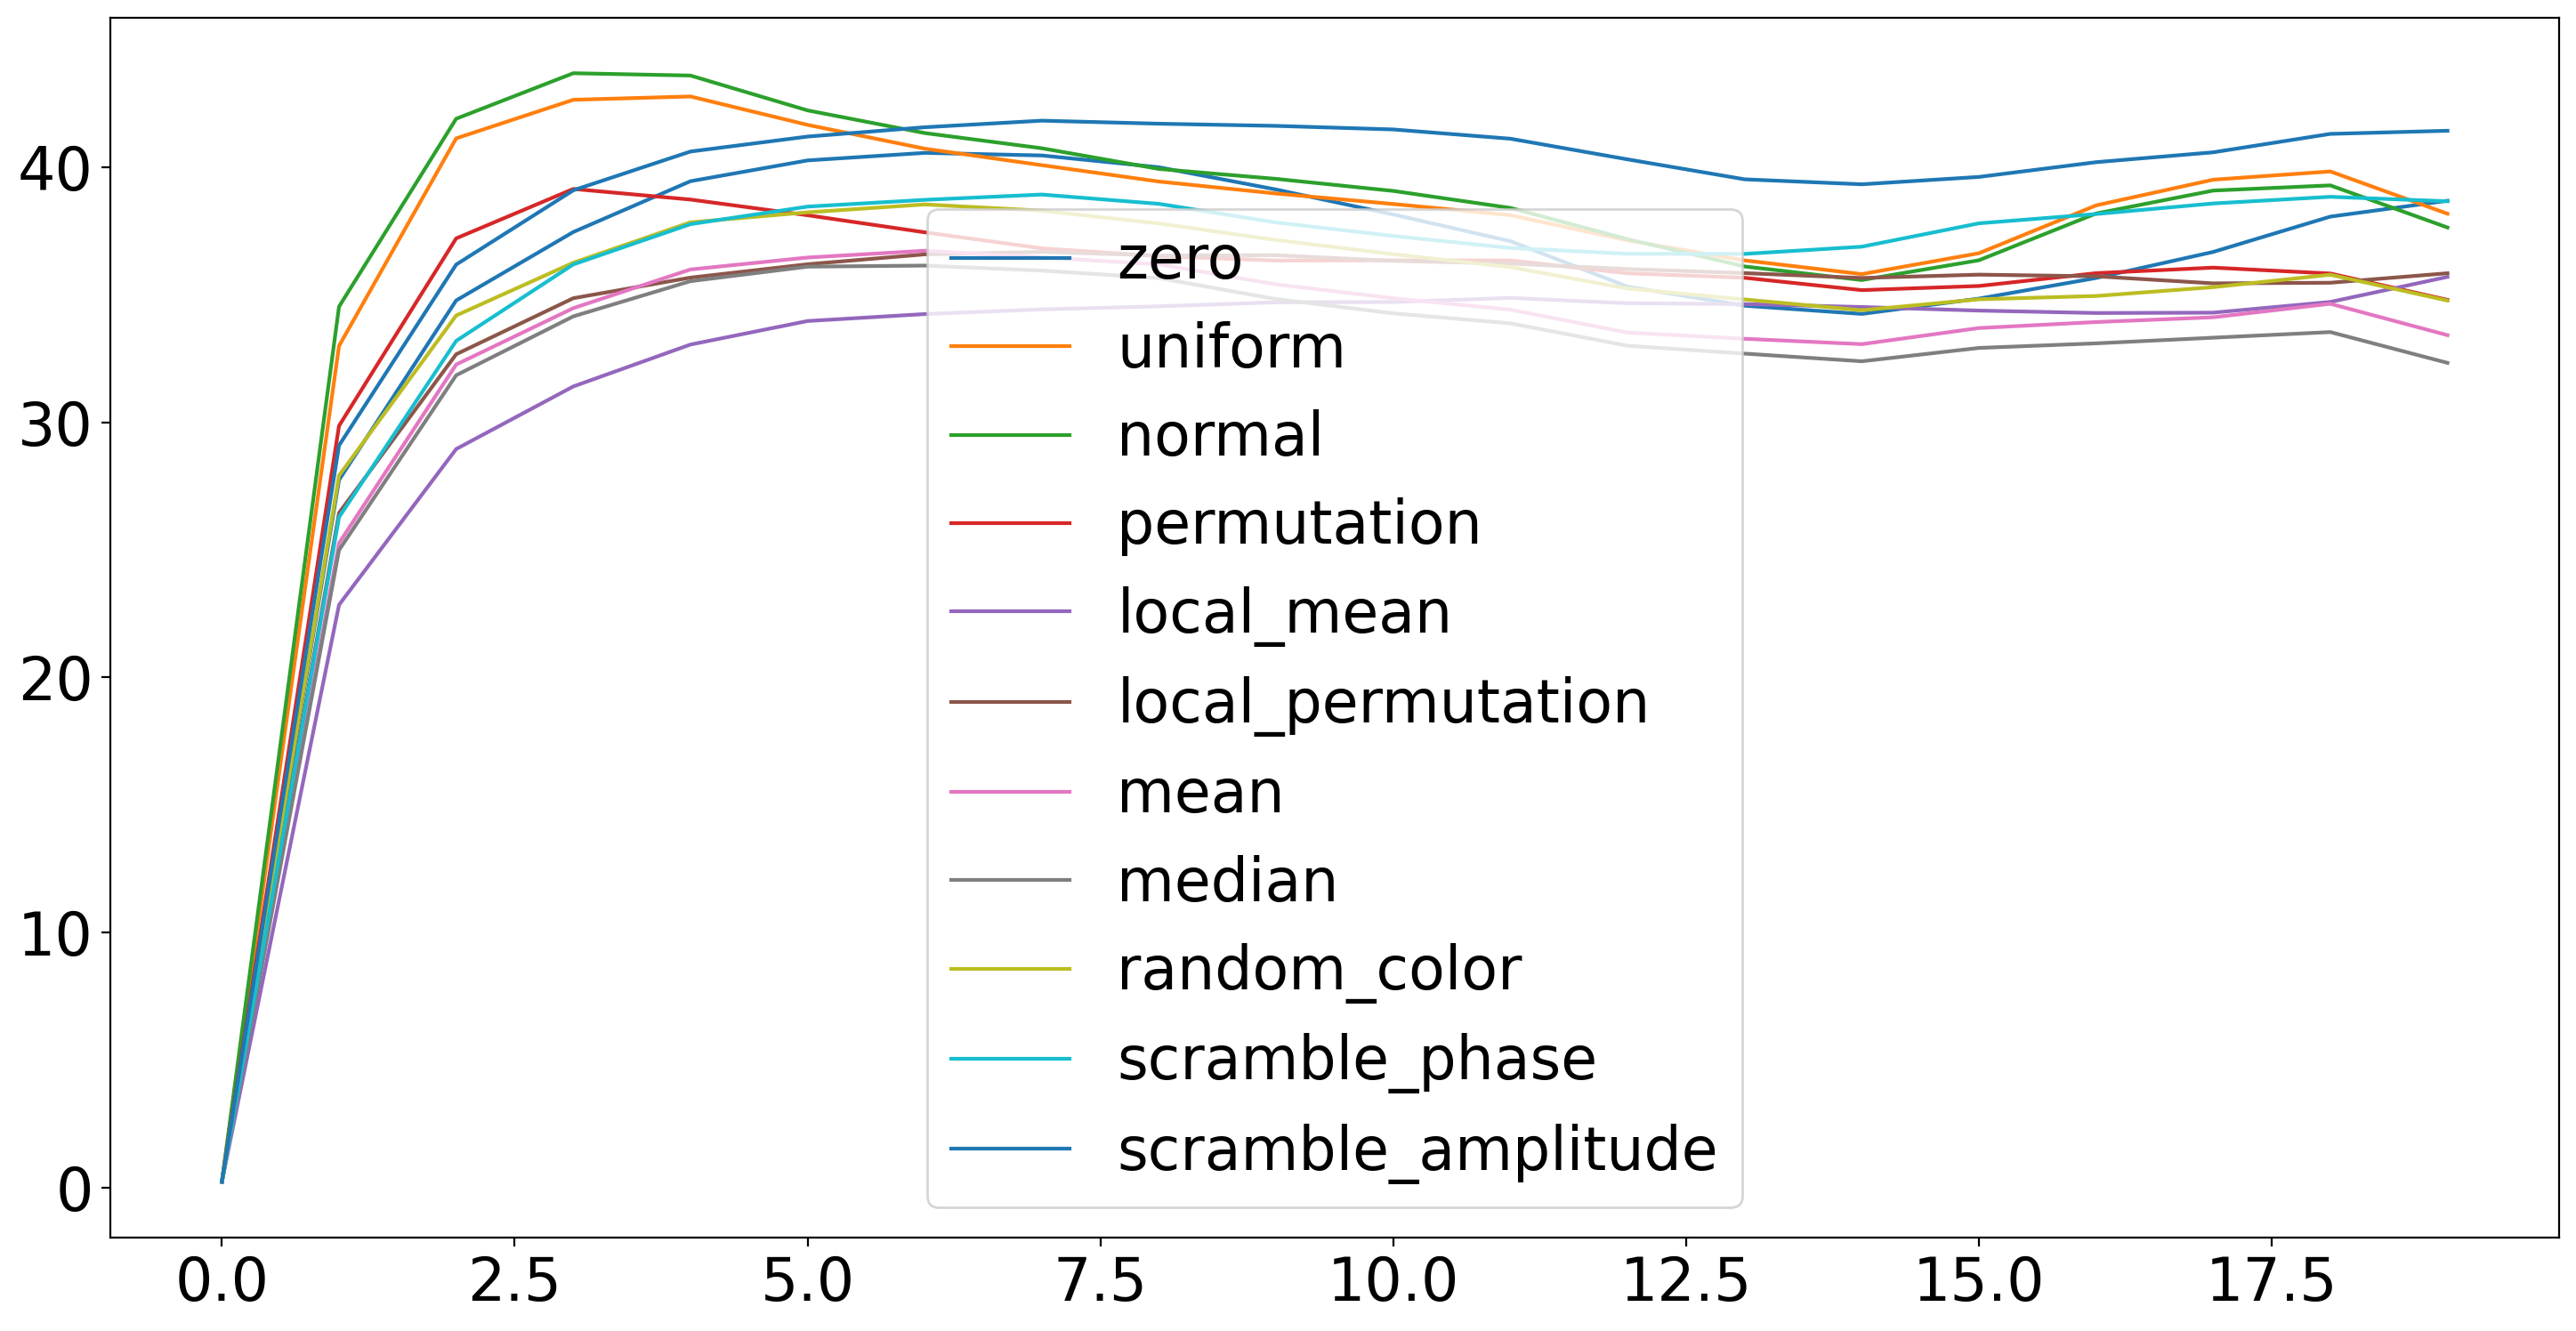

In [28]:
set_size(15, 8)

for baseline_name, baseline_func in baselines.items():
  scores = [np.mean(d) for _, d in RESULTS[baseline_name]]
  plt.plot(scores, label=baseline_name)

plt.tight_layout()
plt.legend()

### Create the figure for Deletion

In [29]:
baseline_to_color = {
'zero' : slack_violet,
'uniform' : palette_1,
'normal' : palette_1,
'permutation' : palette_2,
'local_permutation' : palette_2,
'local_mean' : palette_3,
'mean' : palette_3,
'median' : palette_3,
'random_color' : slack_violet,
'scramble_phase' : palette_4,
'scramble_amplitude' : palette_4,
}

baseline_to_linestyle = {
'zero' : '-',
'uniform' : '-',
'normal' : '--',
'permutation' : '-',
'local_permutation' : '--',
'local_mean' : '-',
'mean' : '--',
'median' : ':',
'random_color' : '--',
'scramble_phase' : '-',
'scramble_amplitude' : '--',
}

baseline_to_symbol = {
'zero' : 'o',
'uniform' : 'o',
'normal' : 'v',
'permutation' : 'o',
'local_permutation' : 'v',
'local_mean' : 'o',
'mean' : 'v',
'median' : 's',
'random_color' : 'v',
'scramble_phase' : 'o',
'scramble_amplitude' : 'v',
}

blue_1 = np.array((96, 148, 200)) / 255.0
blue_2 = np.array((211, 237, 246)) / 255.0
orange_1 = np.array((209, 111, 77)) / 255.0
orange_2 = np.array((248, 232, 192)) / 255.0

In [30]:
results = {}
for baseline in RESULTS.keys():
  ood_curve = [s for _,s in RESULTS[baseline]]
  results[baseline] = ood_curve

/tmp/ipykernel_740303/4062593333.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.arange(len(curve)), curve, c=color(1.0), marker=baseline_to_symbol[baseline],


(-0.2, 19.2)

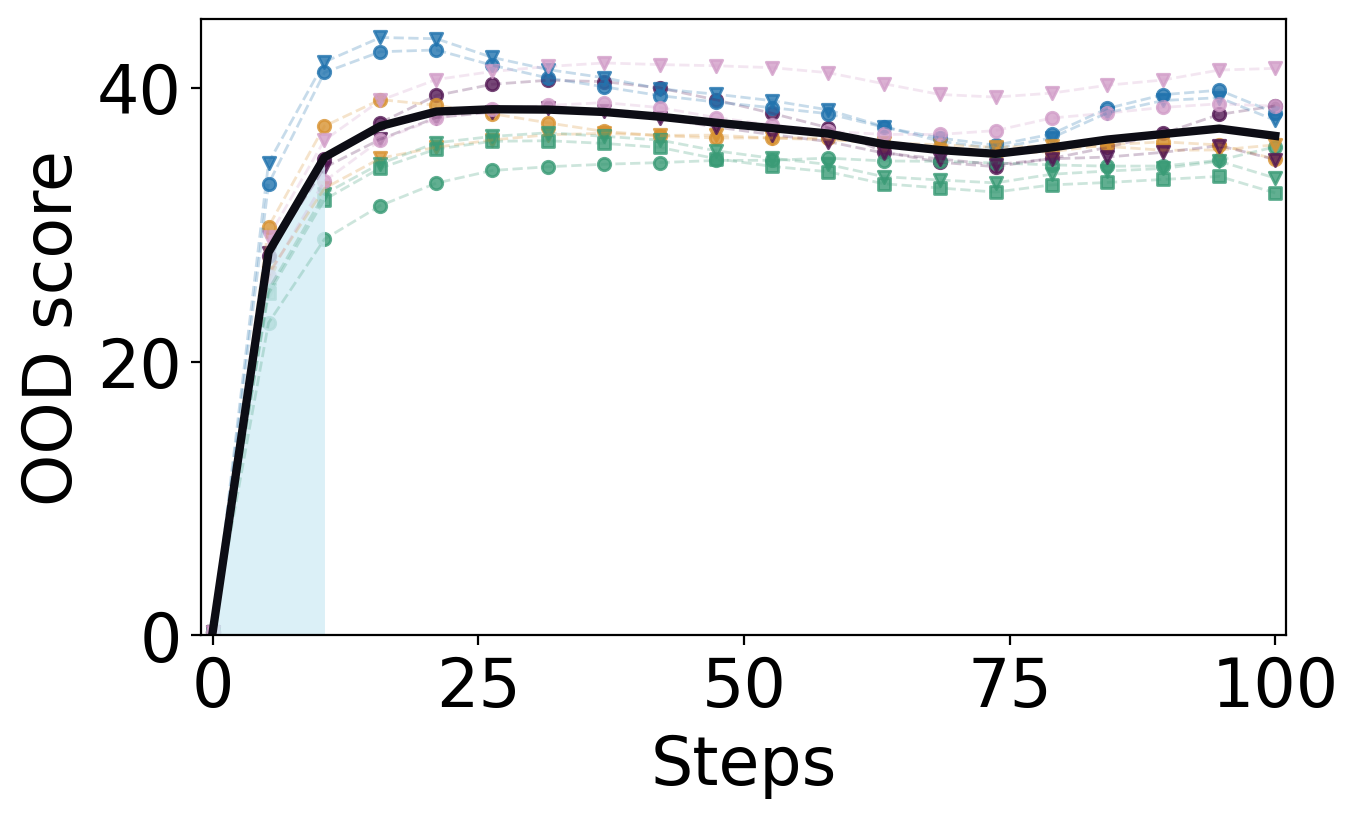

In [31]:
import scipy
import matplotlib as mpl
from scipy import interpolate

mpl.rcdefaults()
fontsize(2.0)
set_size(7, 4)
# plt.style.use("seaborn-ticks")

lw1 = 1.0
lw2 = 3.0
alpha_minor = 0.25

curves = []
for baseline in results:
  points = results[baseline]

  curve = [np.mean(p) for p in points][:]
  stds = [np.std(p) for p in points][:]

  color = baseline_to_color[baseline]
  k = color(1.0)[0]

  curves.append(curve)

  ls = baseline_to_linestyle[baseline]

  #plt.plot(curve, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.8, linestyle=ls)
  plt.scatter(np.arange(len(curve)), curve, c=color(1.0), marker=baseline_to_symbol[baseline],
              label=baseline.replace('_', ' '), alpha=0.8, s=20.0)
  plt.plot(np.arange(len(curve)), curve, linewidth=lw1, c=color(1.0), alpha=alpha_minor, linestyle="--")


mean_curve = np.mean(curves, 0)
plt.plot(np.arange(len(curve)), mean_curve, linewidth=lw2, c=anthracite(1.0), alpha=1.0, linestyle="-", label='Average')
plt.fill_between(np.arange(len(curve))[:int(0.18*len(curve))], mean_curve[:int(0.18*len(curve))]*0.0,
                 mean_curve[:int(0.18*len(curve))], color=blue_2, alpha=.8, linewidth=0.0)

plt.xticks(np.linspace(0, len(curve)-1, 11//2), np.linspace(0, 100, 11//2).astype(np.int32))
plt.xlabel("Steps")
plt.ylabel('OOD score')
plt.ylim([0, 45])
plt.xlim([-0.2, len(curve)-0.8])
# plt.savefig('ood_resnet_deletion.png', dpi=400, transparent=True)
#plt.title()

### Compute the OOD score for Insertion paths

In [18]:
def generate_path_insertion(images, explanations, baseline_func, steps=10):
  images_flatten = np.array(images).reshape((len(images), -1, images.shape[-1]))

  min_img = np.min(images, (1,2,3))
  max_img = np.max(images, (1,2,3))

  if len(explanations.shape) == 4:
    explanations = np.mean(explanations, -1)

  explanations_flatten = explanations.reshape((len(explanations), -1))
  most_important_features = np.argsort(explanations_flatten, axis=-1)[:, ::-1]

  baselines = np.array(baseline_func(images))
  baselines_flatten = baselines.reshape((len(images), -1, images.shape[-1]))

  steps = np.linspace(0, baselines_flatten.shape[1], steps + 1, dtype=np.int32)

  #start = images_flatten
  #end = baselines_flatten

  end = images_flatten
  start = baselines_flatten


  ret = []

  for step in steps:
    ids_to_flip = most_important_features[:, :step]
    batch_inputs = start.copy()

    for i, ids in enumerate(ids_to_flip):
      batch_inputs[i, ids] = end[i, ids]

    batch_inputs = batch_inputs.reshape(images.shape)
    batch_inputs = np.clip(batch_inputs, min_img[:, None, None, None], max_img[:, None, None, None])
    ret.append(batch_inputs)

  return ret

In [19]:
steps = 20

RESULTS = {}
for baseline_name, baseline_func in baselines.items():
  RESULTS[baseline_name] = []

  chunks = generate_path_insertion(np.array(X[:len(H)]), np.array(H), baseline_func, steps=steps)

  for step_id in range(steps):
    ood_scores = compute_ood_score(chunks[step_id])
    RESULTS[baseline_name].append((step_id, ood_scores))

  print("done for", baseline_name)

2/2 [==============================] - 0s 48ms/step
done for zero
2/2 [==============================] - 0s 46ms/step
done for uniform
2/2 [==============================] - 0s 50ms/step
done for normal
2/2 [==============================] - 0s 46ms/step
done for permutation
2/2 [==============================] - 0s 48ms/step
done for local_mean
2/2 [==============================] - 0s 47ms/step
done for local_permutation
2/2 [==============================] - 0s 48ms/step
done for mean
2/2 [==============================] - 0s 47ms/step
done for median
2/2 [==============================] - 0s 48ms/step
done for random_color
2/2 [==============================] - 0s 47ms/step
done for scramble_phase
2/2 [==============================] - 0s 48ms/step
done for scramble_amplitude


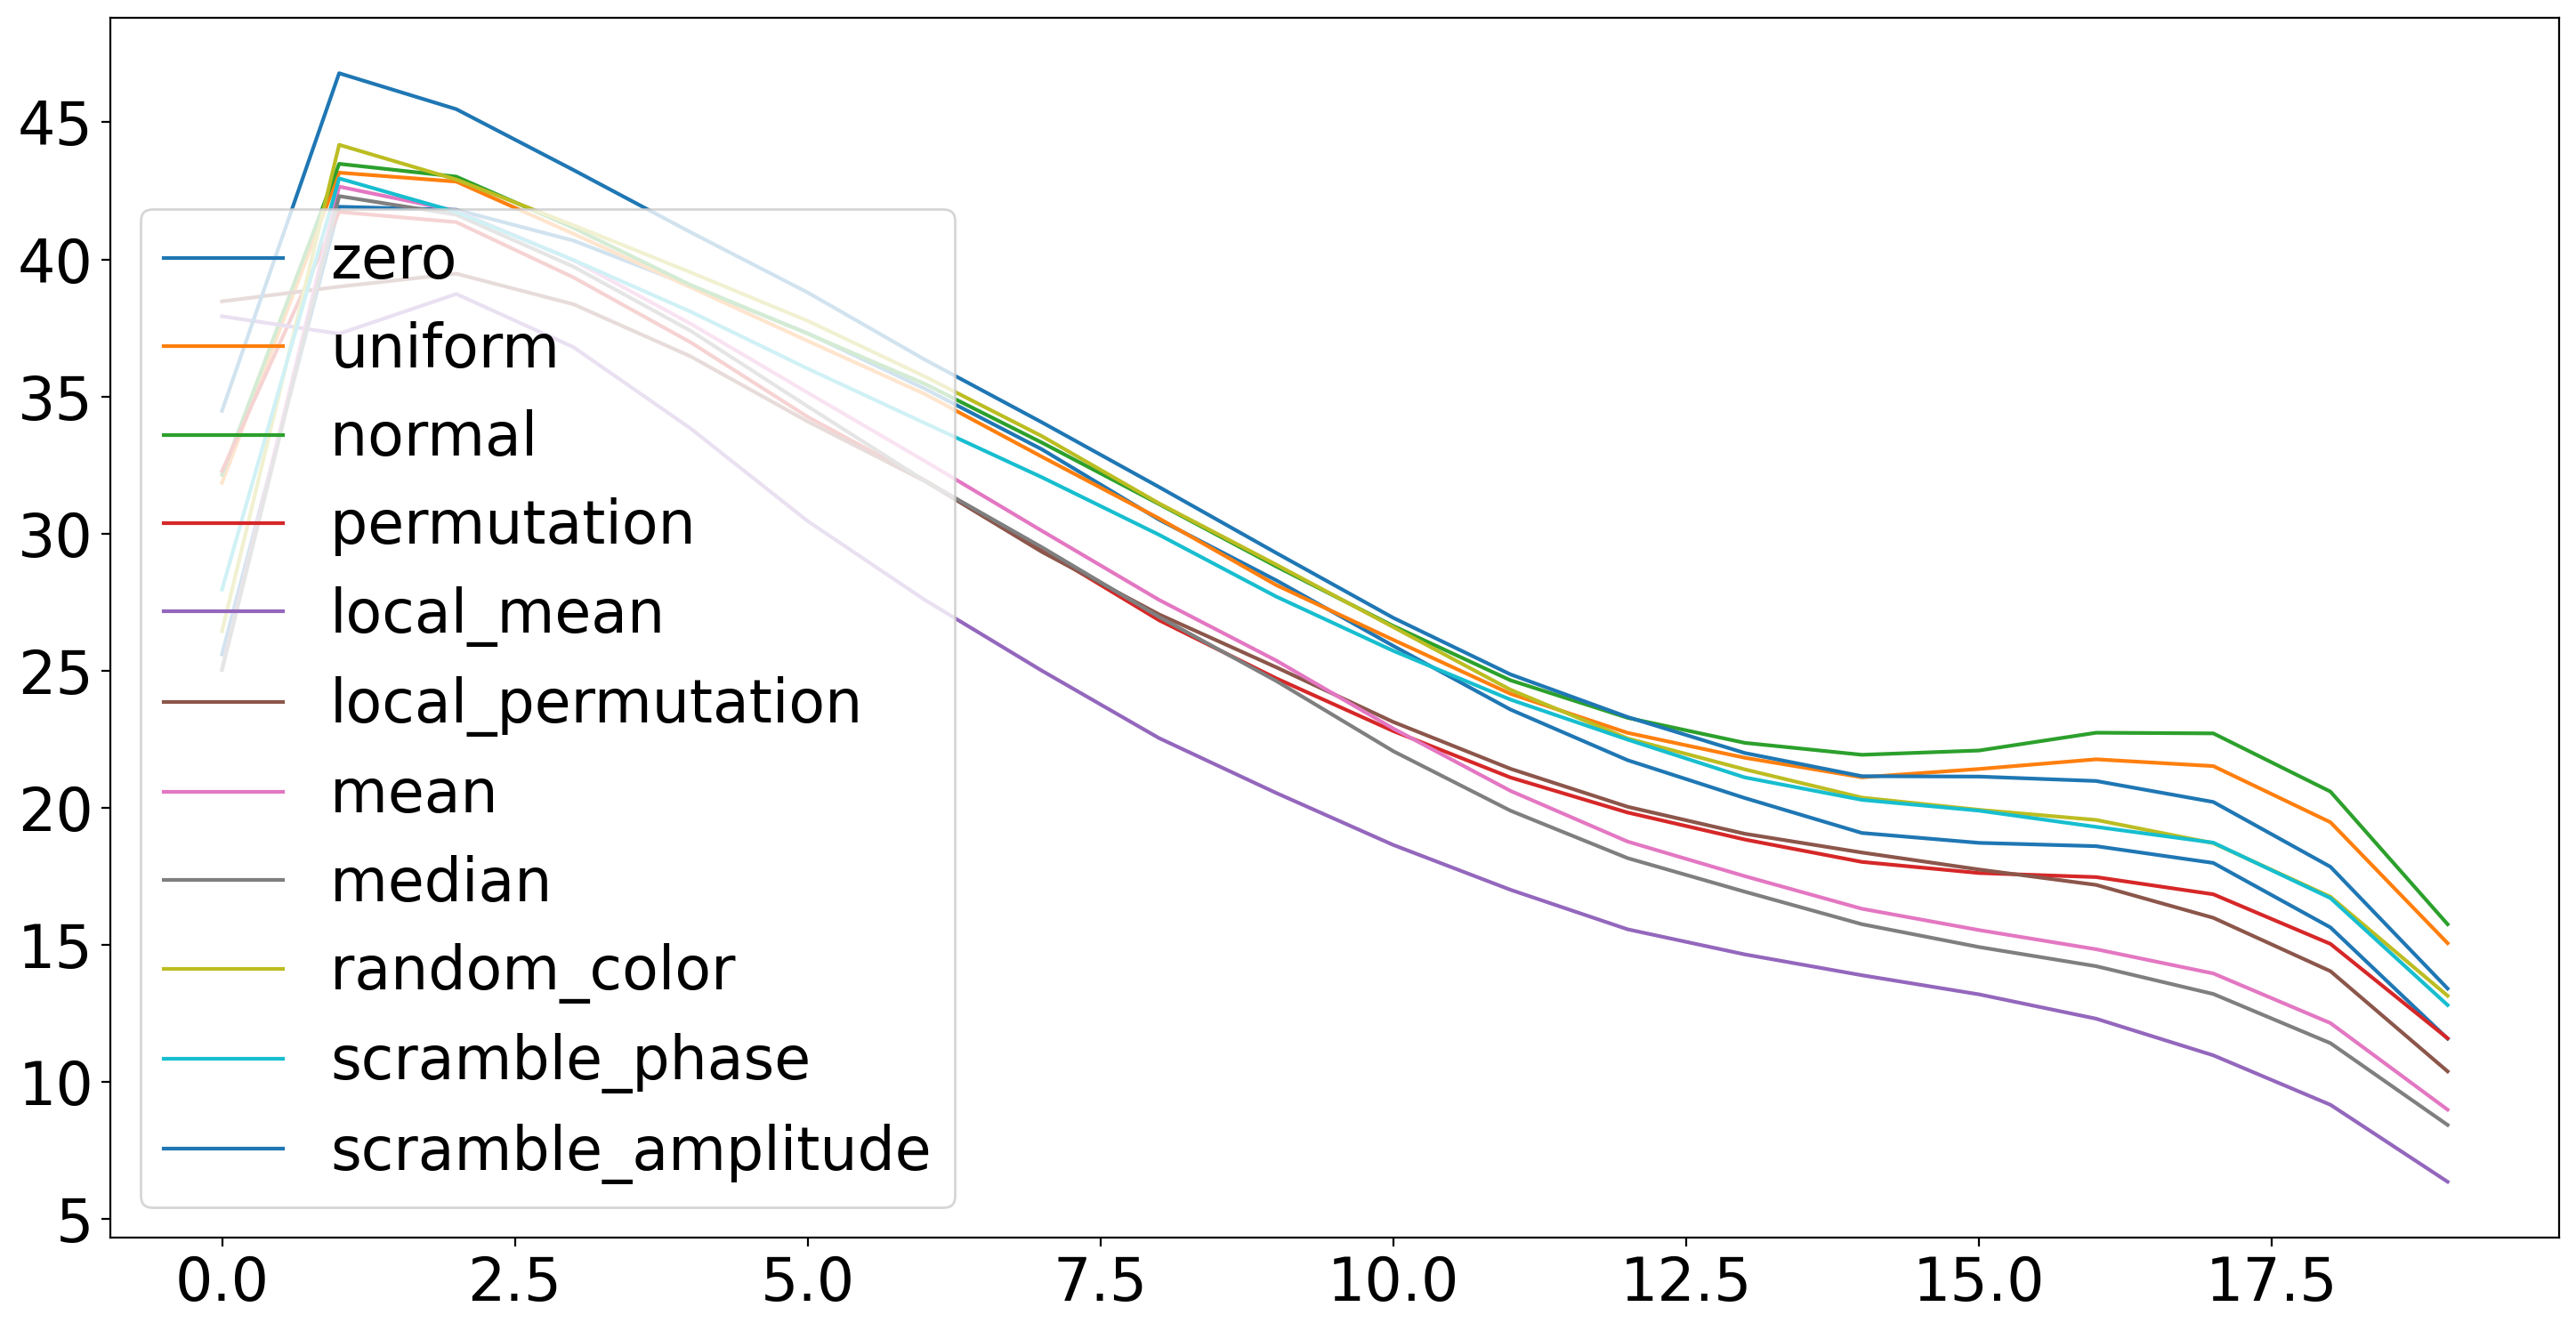

In [20]:
set_size(15, 8)

for baseline_name, baseline_func in baselines.items():
  scores = [np.mean(d) for _, d in RESULTS[baseline_name]]
  plt.plot(scores, label=baseline_name)

plt.tight_layout()
plt.legend()

### Create the figure for Insertion

In [21]:
results = {}
for baseline in RESULTS.keys():
  ood_curve = [s for _,s in RESULTS[baseline]]
  results[baseline] = ood_curve

/tmp/ipykernel_740303/1801442947.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.arange(len(curve)), curve, c=color(1.0), marker=baseline_to_symbol[baseline],


(-0.2, 19.2)

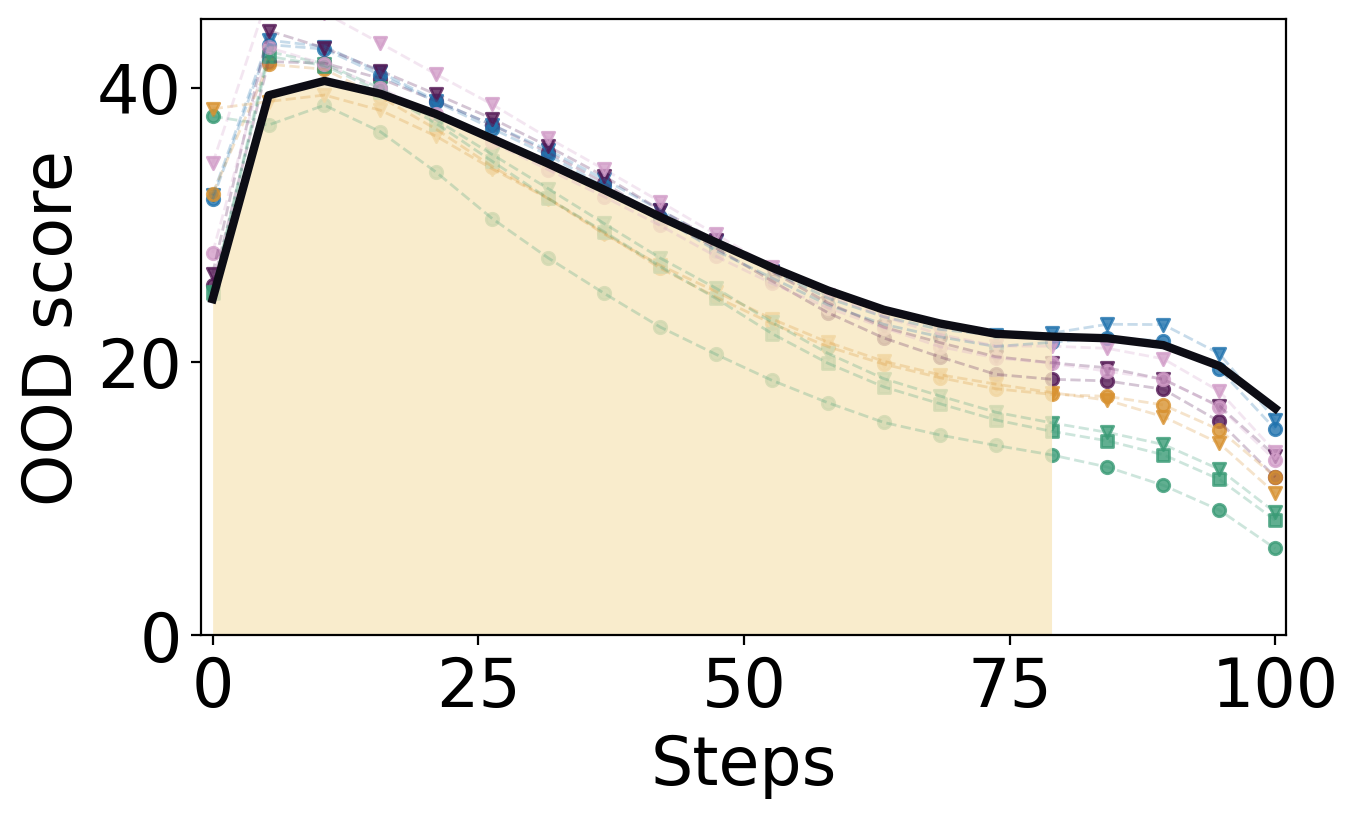

In [25]:
mpl.rcdefaults()
fontsize(2.0)
set_size(7, 4)
# plt.style.use("seaborn-ticks")

lw1 = 1.0
lw2 = 3.0
alpha_minor = 0.25

for baseline in results:
  points = results[baseline]

  curve = [np.mean(p) for p in points][:]
  stds = [np.std(p) for p in points][:]

  color = baseline_to_color[baseline]
  k = color(1.0)[0]

  curves.append(curve)

  ls = baseline_to_linestyle[baseline]
  plt.scatter(np.arange(len(curve)), curve, c=color(1.0), marker=baseline_to_symbol[baseline],
              label=baseline.replace('_', ' '), alpha=0.8, s=20.0)
  plt.plot(np.arange(len(curve)), curve, linewidth=lw1, c=color(1.0), alpha=alpha_minor, linestyle="--")


mean_curve = np.mean(curves, 0)
plt.plot(np.arange(len(curve)), mean_curve, linewidth=lw2, c=anthracite(1.0), alpha=1.0, linestyle="-", label='Average')
plt.fill_between(np.arange(len(curve))[:int(0.81*len(curve))], mean_curve[:int(0.81*len(curve))]*0.0,
                 mean_curve[:int(0.81*len(curve))], color=orange_2, alpha=.8, linewidth=0.0)

plt.xticks(np.linspace(0, len(curve)-1, 11//2), np.linspace(0, 100, 11//2).astype(np.int32))
plt.xlabel("Steps")
plt.ylabel('OOD score')
plt.ylim([0, 45])
plt.xlim([-0.2, len(curve)-0.8])
# plt.savefig('ood_resnet_insertion.png', dpi=400, transparent=True)
# #plt.title()